<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg" />
</center> 
     
## <center>  [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 

#### <center> Author: [Yury Kashnitsky](https://yorko.github.io) (@yorko) 

# <center>Assignment #2. Fall 2019
## <center> Part 2. Gradient boosting

**In this assignment, you're asked to beat a baseline in the ["Flight delays" competition](https://www.kaggle.com/c/flight-delays-fall-2018).**

This time we decided to share a pretty decent CatBoost baseline, you'll have to improve the provided solution.

Prior to working on the assignment, you'd better check out the corresponding course material:
 1. [Classification, Decision Trees and k Nearest Neighbors](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic03_decision_trees_kNN/topic3_decision_trees_kNN.ipynb?flush_cache=true), the same as an interactive web-based [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-3-decision-trees-and-knn) 
 2. Ensembles:
  - [Bagging](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part1_bagging.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-1-bagging)
  - [Random Forest](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part2_random_forest.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-2-random-forest)
  - [Feature Importance](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part3_feature_importance.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-3-feature-importance)
 3. - [Gradient boosting](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic10_boosting/topic10_gradient_boosting.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-10-gradient-boosting) 
   - Logistic regression, Random Forest, and LightGBM in the "Kaggle Forest Cover Type Prediction" competition: [Kernel](https://www.kaggle.com/kashnitsky/topic-10-practice-with-logit-rf-and-lightgbm) 
 4. You can also practice with demo assignments, which are simpler and already shared with solutions:
  - "Decision trees with a toy task and the UCI Adult dataset": [assignment](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees) + [solution](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees-solution)
  - "Logistic Regression and Random Forest in the credit scoring problem": [assignment](https://www.kaggle.com/kashnitsky/assignment-5-logit-and-rf-for-credit-scoring) + [solution](https://www.kaggle.com/kashnitsky/a5-demo-logit-and-rf-for-credit-scoring-sol)
 5. There are also 7 video lectures on trees, forests, boosting and their applications: [mlcourse.ai/video](https://mlcourse.ai/video) 
 6. mlcourse.ai tutorials on [categorical feature encoding](https://www.kaggle.com/waydeherman/tutorial-categorical-encoding) (by Wayde Herman) and [CatBoost](https://www.kaggle.com/mitribunskiy/tutorial-catboost-overview) (by Mikhail Tribunskiy)
 7. Last but not the least: [Public Kernels](https://www.kaggle.com/c/flight-delays-fall-2018/notebooks) in this competition

### Your task is to:
 1. beat **"A2 baseline (10 credits)"** on Public LB (**0.75914** LB score)
 2. rename your [team](https://www.kaggle.com/c/flight-delays-fall-2018/team) in full accordance with A1 and the [course rating](https://docs.google.com/spreadsheets/d/15e1K0tg5ponA5R6YQkZfihrShTDLAKf5qeKaoVCiuhQ/) (to appear on 16.09.2019)
 
This task is intended to be relatively easy. Here you are not required to upload your reproducible solution.
 
### <center> Deadline for A2: 2019 October 6, 20:59 CET (London time)

In [82]:
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = 11, 8

**Read the data**

In [83]:
train_df = pd.read_csv('flight_delays_train.csv')
test_df = pd.read_csv('flight_delays_test.csv')

In [84]:
train_df.head()
# sns.pairplot(train_df, hue='dep_delayed_15min')

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [67]:
test_df.head()
# test_df['DepTime > 1250'] = test_df['DepTime'] > 1250
# test_df['DepTime > 1250'] = test_df['DepTime > 1250'].map({True: 'Y', False: 'N'})

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


In [47]:
# a = train_df[train_df['dep_delayed_15min'] == 'Y']['DepTime']
# print(a.mean())
# def interval(n, k, data):
#     pop = []
#     for _ in range(n):
#         pop.append(np.random.choice(data, k).mean())
#     return pop
# d = interval(1000, 50, a)
# sns.distplot(d);
# d = np.array(d)
# d.mean(), d.std()
# delay_interval = (a.mean() - 2 * d.std(), a.mean() + 2 * d.std())

In [48]:
# a = train_df[train_df['dep_delayed_15min'] == 'N']['DepTime']
# print(a.mean())
# def interval(n, k, data):
#     pop = []
#     for _ in range(n):
#         pop.append(np.random.choice(data, k).mean())
#     return pop
# d = interval(1000, 50, a)
# sns.distplot(d);
# d = np.array(d)
# d.mean(), d.std()
# no_delay_intreval = (a.mean() - 2 * d.std(), a.mean() + 2 * d.std())

In [49]:
# no_delay_intreval, delay_interval

**Create only one feature - “flight” (this you need to improve - add more features)**

In [85]:
# def check_dep_time(value):
#     if no_delay_intreval[0] <= value <= no_delay_intreval[1]:
#         return 'no_delay'
#     if delay_interval[0] <= value <= delay_interval[1]:
#         return 'delay'
#     return 'unknown'

def check_dep_hour(value):
    if value > 14:
        return 'delay'
    if value <= 14:
        return 'no_delay'


def make_conj(df1, df2, feature1, feature2):
    df1[feature1 + ' + ' + feature2] = df1[feature1].astype(str) + ' + ' + df1[feature2].astype(str)
    df2[feature1 + ' + ' + feature2] = df2[feature1].astype(str) + ' + ' + df2[feature2].astype(str)
    return df1, df2


# train_df['flight'] = train_df['Origin'] + '-->' + train_df['Dest']
# test_df['flight'] = test_df['Origin'] + '-->' + test_df['Dest']

# train_df['time/carrier'] = train_df['DepTime'].apply(str) + '/' + train_df['UniqueCarrier']
# test_df['time/carrier'] = test_df['DepTime'].apply(str) + '/' + test_df['UniqueCarrier']

# make_conj(train_df, test_df, 'DepTime', 'UniqueCarrier')
# make_conj(train_df, test_df, 'DepTime', 'Origin')
# make_conj(train_df, test_df, 'DepTime', 'Dest')
# make_conj(train_df, test_df, 'Origin', 'Dest')
# make_conj(train_df, test_df, 'Month', 'UniqueCarrier')

def inter(value):
    if value < -2:
        return '(-inf, -2)'
    if -2 <= value < -1:
        return '[-2, 1)'
    if -1 <= value < 0:
        return '[-1, 0)'
    if 0 <= value < 1:
        return '[0, 1)'
    if 1 <= value < 2:
        return '[1, 2)'
    if value >= 2:
        return '[2, +inf)'
    return '0'

# train_df['interval_dep_time'] = train_df['DepTime'].apply(inter)
# test_df['interval_dep_time'] = test_df['DepTime'].apply(inter)

# train_df['median_dep_time'] = train_df['DepTime'] > 0
# test_df['median_dep_time'] = test_df['DepTime'] > 0
# train_df['median_dep_time'] = train_df['median_dep_time'].map({True: 'Y', False: 'N'})
# test_df['median_dep_time'] = test_df['median_dep_time'].map({True: 'Y', False: 'N'})

# make_conj(train_df, test_df, 'Month', 'interval_dep_time')
# make_conj(train_df, test_df, 'Month', 'Dest')
# make_conj(train_df, test_df, 'Month', 'UniqueCarrier')
# make_conj(train_df, test_df, 'interval_dep_time', 'Origin + Dest')
# make_conj(train_df, test_df, 'DayOfWeek', 'UniqueCarrier')
# make_conj(train_df, test_df, 'interval_dep_time', 'UniqueCarrier')

# make_conj(train_df, test_df, 'DepTime', 'Month')
# make_conj(train_df, test_df, 'DepTime', 'Dest')
# make_conj(train_df, test_df, 'DepTime', 'Origin')
# make_conj(train_df, test_df, 'DepTime', 'UniqueCarrier')


# train_df.drop(columns='Distance', inplace=True)
# test_df.drop(columns='Distance', inplace=True)

# Seasons

# seasons = {'c-6': 'Summer',
#           'c-7': 'Summer',
#           'c-8': 'Summer',
#           'c-9': 'Autumn',
#           'c-10': 'Autumn',
#           'c-11': 'Autumn',
#           'c-12': 'Winter',
#           'c-1': 'Winter',
#           'c-2': 'Winter',
#           'c-3': 'Spring',
#           'c-4': 'Spring',
#           'c-5': 'Spring',
    
# }

# train_df['season'] = train_df['Month'].map(seasons) 
# test_df['season'] = test_df['Month'].map(seasons) 

# Day of week
dayOfWeek={'c-1':'Sunday', 'c-2':'Monday', 'c-3':'Tuesday', 'c-4':'Wednesday', 'c-5':'Thursday', 'c-6':'Friday',
           'c-7':'Saturday'}
train_df['DayOfWeek'] = train_df['DayOfWeek'].map(dayOfWeek)
test_df['DayOfWeek'] = test_df['DayOfWeek'].map(dayOfWeek)

# Month
mon_map = {'c-1': 'Jan', 'c-2': 'Feb', 'c-3': 'Mar', 'c-4': 'Apr', 'c-5': 'May',
            'c-6': 'Jun', 'c-7': 'Jul', 'c-8': 'Aug', 'c-9': 'Sep', 'c-10': 'Oct', 'c-11': 'Nov', 'c-12': 'Dec'}
train_df['Month'] = train_df['Month'].map(mon_map)
test_df['Month'] = test_df['Month'].map(mon_map)

# Convert DepTime in new features

train_df['Dep_hour'] =  train_df['DepTime']//100
train_df['Dep_minute'] =  train_df['DepTime']%100
train_df['Dep_hour'].replace(to_replace=[24,25], value=0, inplace=True)

test_df['Dep_hour'] =  test_df['DepTime']//100
test_df['Dep_minute'] =  test_df['DepTime']%100
test_df['Dep_hour'].replace(to_replace=[24,25], value=0, inplace=True)

test_df.drop(columns='DepTime', inplace=True)
train_df.drop(columns='DepTime', inplace=True)

make_conj(train_df, test_df, 'Dep_hour', 'UniqueCarrier')
make_conj(train_df, test_df, 'Origin', 'Dest');
# train_df['Distance'] = train_df['Distance'] // 100
# make_conj(train_df, test_df, 'Distance', 'UniqueCarrier');
# make_conj(train_df, test_df, 'Dep_minute', 'UniqueCarrier');
# make_conj(train_df, test_df, 'DayofMonth', 'DayOfWeek')
make_conj(train_df, test_df, 'Dep_hour + UniqueCarrier', 'Origin');
# train_df['was_delay'] = train_df['Dep_hour'].apply(check_dep_hour)
# test_df['was_delay'] = test_df['Dep_hour'].apply(check_dep_hour)


# train_df['month/carrier'] = train_df['Month'] + '/' + train_df['UniqueCarrier']
# test_df['month/carrier'] = test_df['Month'] + '/' + test_df['UniqueCarrier']


# train_df['time/origin'] = train_df['DepTime'].apply(str) + '/' + train_df['Origin']
# test_df['time/origin'] = test_df['DepTime'].apply(str) + '/' + test_df['Origin']

# train_df['DepTime > 1250'] = train_df['DepTime'] > 1250
# train_df['DepTime > 1250'] = train_df['DepTime > 1250'].map({True: 'Y', False: 'N'})
# test_df['DepTime > 1250'] = test_df['DepTime'] > 1250
# test_df['DepTime > 1250'] = test_df['DepTime > 1250'].map({True: 'Y', False: 'N'})



In [86]:
train_df['Distance_500'] = train_df['Distance'].apply(lambda x: str(x // 100))
test_df['Distance_500'] = test_df['Distance'].apply(lambda x: str(x // 100))
make_conj(train_df, test_df, 'Distance_500', 'UniqueCarrier')
# train_df = train_df.drop(columns=['Distance', 'DayofMonth', 'Distance_500'])
# test_df = test_df.drop(columns=['Distance', 'DayofMonth', 'Distance_500'])
make_conj(train_df, test_df, 'Month', 'DayofMonth')
make_conj(train_df, test_df, 'Month + DayofMonth', 'DayOfWeek')
make_conj(train_df, test_df, 'Dep_minute', 'Distance')
# train_df['Distance ln'] = np.log(train_df['Distance'] + 1)
# test_df['Distance ln'] = np.log(test_df['Distance'] + 1)
train_df['Dep_hour square'] = train_df['Dep_hour'] ** 2
test_df['Dep_hour square'] = test_df['Dep_hour'] ** 2
train_df['hour ^ dist'] = train_df['Dep_hour'] * train_df['Distance']
test_df['hour ^ dist'] = test_df['Dep_hour'] * test_df['Distance']
train_df['hour ^ min'] = train_df['Dep_hour'] * train_df['Dep_minute']
test_df['hour ^ min'] = test_df['Dep_hour'] * test_df['Dep_minute']
train_df['Min ^ 2'] = train_df['Dep_minute'] ** 2
test_df['Min ^ 2'] = test_df['Dep_minute'] ** 2


# train_df.drop(columns=['Month', 'DayofMonth', 'DayOfWeek', 'Month + DayofMonth', 'Distance_500'])

In [87]:
train_df = train_df.drop(columns=['Month', 'DayofMonth', 'DayOfWeek', 'Month + DayofMonth', 'Distance_500'])
test_df = test_df.drop(columns=['Month', 'DayofMonth', 'DayOfWeek', 'Month + DayofMonth', 'Distance_500'])

In [53]:
# train_df[train_df['dep_delayed_15min'] == 'Y']['Dep_minute'].hist()

In [179]:
# train_df[train_df['dep_delayed_15min'] == 'N']['Dep_minute'].hist()

15.490023104389834


(14.179892070332553, 16.800154138447116)

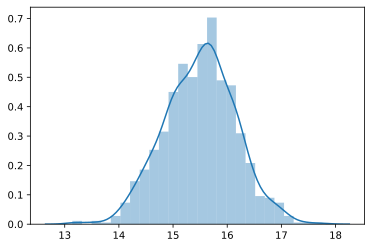

In [11]:
a = train_df[train_df['dep_delayed_15min'] == 'Y']['Dep_hour']
print(a.mean())
def interval(n, k, data):
    pop = []
    for _ in range(n):
        pop.append(np.random.choice(data, k).mean())
    return pop
d = interval(1000, 50, a)
sns.distplot(d);
d = np.array(d)
d.mean(), d.std()
delay_interval = (a.mean() - 2 * d.std(), a.mean() + 2 * d.std())
delay_interval

In [18]:
b = train_df[train_df['dep_delayed_15min'] == 'Y'][['Dep_hour']]
b[(b['Dep_hour'] >= 14) & (b['Dep_hour'] <= 17)].__len__()
train_df[(train_df['Dep_hour'] >= 14) & (train_df['Dep_hour'] <= 17)]

24850

In [87]:
# sns.boxplot(x=train_df['UniqueCarrier'], y=train_df['Distance'])

In [88]:
# sns.boxplot(x=train_df[train_df['dep_delayed_15min'] == 'Y']['UniqueCarrier'],
#             y=train_df[train_df['dep_delayed_15min'] == 'Y']['Distance'])

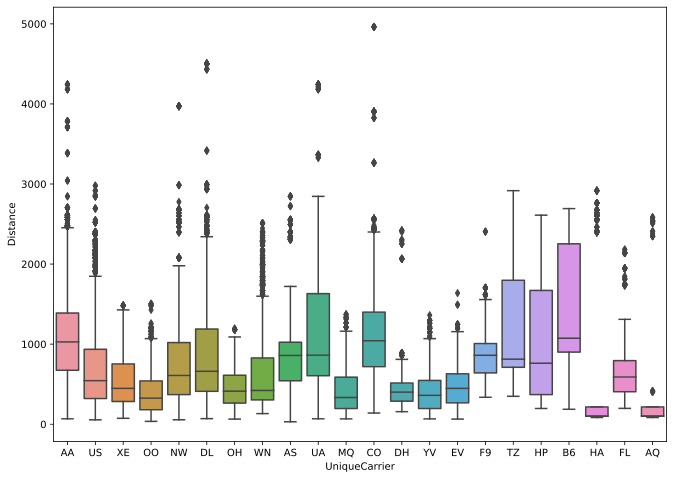

In [138]:
sns.boxplot(x=train_df[train_df['dep_delayed_15min'] == 'N']['UniqueCarrier'],
            y=train_df[train_df['dep_delayed_15min'] == 'N']['Distance'])

In [114]:
q = train_df[train_df['dep_delayed_15min'] == 'Y']['Dep_minute']
w = train_df[train_df['dep_delayed_15min'] == 'N']['Dep_minute']
e = train_df['Dep_m']

In [77]:
# sns.distplot(q)

In [78]:
# sns.distplot(w)

In [79]:
# sns.distplot(e)

12.553288205939028


(11.646541063162307, 13.429898936837695)

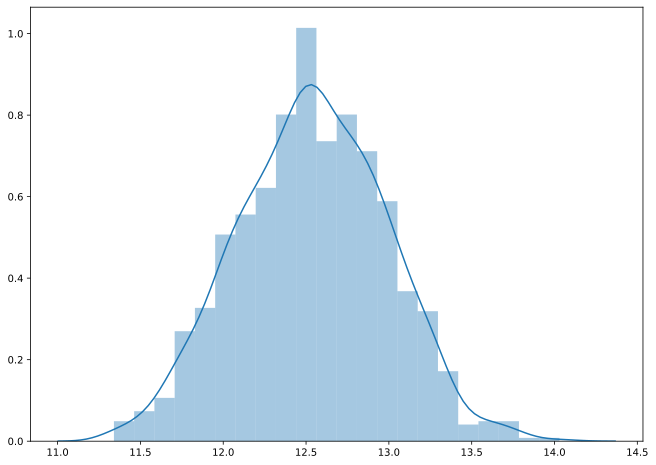

In [101]:
a = train_df[train_df['dep_delayed_15min'] == 'N']['Dep_hour']
print(a.mean())
def interval(n, k, data):
    pop = []
    for _ in range(n):
        pop.append(np.random.choice(data, k).mean())
    return pop
d = interval(1000, 100, a)
sns.distplot(d);
d = np.array(d)
d.mean(), d.std()
no_delay_intreval = (d.mean() - 2 * d.std(), d.mean() + 2 * d.std())
no_delay_intreval

(14.578268205329374, 16.37871179467062)

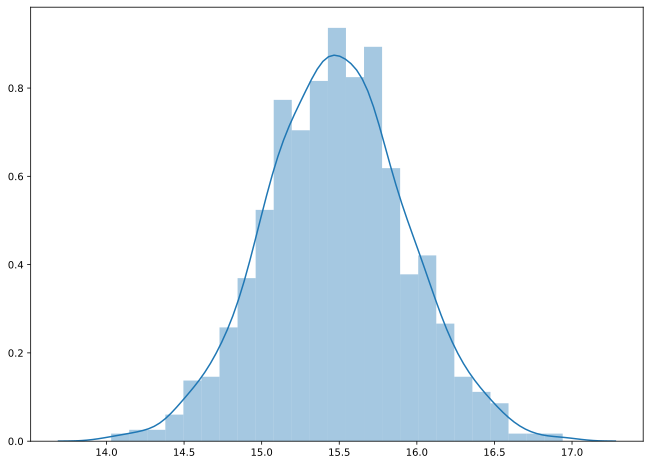

In [100]:
a = train_df[train_df['dep_delayed_15min'] == 'Y']['Dep_hour']
# print(a.mean())
def interval(n, k, data):
    pop = []
    for _ in range(n):
        pop.append(np.random.choice(data, k).mean())
    return pop
d = interval(1000, 100, a)
sns.distplot(d);
d = np.array(d)
d.mean(), d.std()
no_delay_intreval = (d.mean() - 2 * d.std(), d.mean() + 2 * d.std())
no_delay_intreval

In [84]:
def month_countplot(df, mon):
    sns.countplot(x=df[df['Month'] == mon]['DayofMonth'], hue=df[df['Month'] == mon]['dep_delayed_15min']).set_title(mon)

In [57]:
# train_df[train_df['dep_delayed_15min'] == 'Y']['DayOfWeek'].value_counts()
# train_df['DayofMonth'] = train_df['DayofMonth'].apply(lambda x: x[2:]).astype('int64')
# sns.countplot(x=train_df[train_df['Month'] == 'Jan']['DayofMonth'].sort_values(), hue=train_df[train_df['Month'] == 'Jan']['dep_delayed_15min'].sort_values())
# month_countplot(train_df, 'Jan')

In [56]:
# month_countplot(train_df, 'Feb')

In [55]:
# month_countplot(train_df, 'Mar')

In [54]:
# month_countplot(train_df, 'Apr')

In [53]:
# month_countplot(train_df, 'May')

In [52]:
# month_countplot(train_df, 'Jun')

In [51]:
# month_countplot(train_df, 'Jul')

In [50]:
# month_countplot(train_df, 'Aug')

In [49]:
# month_countplot(train_df, 'Sep')

In [48]:
# month_countplot(train_df, 'Oct')

In [47]:
# month_countplot(train_df, 'Nov')

In [58]:
# month_countplot(train_df, 'Dec')

In [59]:
# sns.countplot(x=train_df['DayOfWeek'])

In [60]:
# sns.countplot(x=train_df[train_df['Month'] == 'Aug']['UniqueCarrier'], hue=train_df['dep_delayed_15min']).set_title('Day of week')

In [190]:
# def time_of_day(time):
#     if 0 < time <= 4:
#         return 'night'
#     if 4 < time <= 12:
#         return 'morning'
#     if 12 < time <= 17:
#         return 'afternoon'
#     if (17 <= time <= 23) or (time == 0):
#         return 'evening'

In [191]:
# train_df['day_time'] = train_df['Dep_hour'].apply(time_of_day)
# test_df['day_time'] = test_df['Dep_hour'].apply(time_of_day)
# train_df.drop(columns='Dep_hour', inplace=True)
# test_df.drop(columns='Dep_hour', inplace=True)

In [196]:
train_df.head()
# train_df.info()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,Dep_hour,Dep_minute,Dep_hour + UniqueCarrier,Origin + Dest,Dep_hour + UniqueCarrier + Origin
0,Aug,c-21,Saturday,AA,ATL,DFW,732,N,19,34,19 + AA,ATL + DFW,19 + AA + ATL
1,Apr,c-20,Tuesday,US,PIT,MCO,834,N,15,48,15 + US,PIT + MCO,15 + US + PIT
2,Sep,c-2,Thursday,XE,RDU,CLE,416,N,14,22,14 + XE,RDU + CLE,14 + XE + RDU
3,Nov,c-25,Friday,OO,DEN,MEM,872,N,10,15,10 + OO,DEN + MEM,10 + OO + DEN
4,Oct,c-7,Friday,WN,MDW,OMA,423,Y,18,28,18 + WN,MDW + OMA,18 + WN + MDW


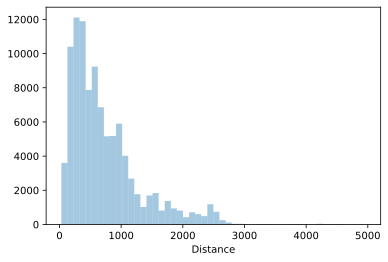

In [21]:
sns.distplot(train_df['Distance'], kde=False)

In [80]:
test_df.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,Dep_hour,Dep_minute,Dep_hour + UniqueCarrier,Origin + Dest,Dep_hour + UniqueCarrier + Origin,Distance_500
0,Jul,c-25,Tuesday,YV,MRY,PHX,598,6,15,6 + YV,MRY + PHX,6 + YV + MRY,19
1,Apr,c-17,Monday,WN,LAS,HOU,1235,7,39,7 + WN,LAS + HOU,7 + WN + LAS,41
2,Dec,c-2,Saturday,MQ,GSP,ORD,577,6,51,6 + MQ,GSP + ORD,6 + MQ + GSP,19
3,Mar,c-25,Saturday,WN,BWI,MHT,377,16,14,16 + WN,BWI + MHT,16 + WN + BWI,12
4,Jun,c-6,Tuesday,UA,ORD,STL,258,15,5,15 + UA,ORD + STL,15 + UA + ORD,8


**Remember indexes of categorical features (to be passed to CatBoost)**

In [88]:
categ_feat_idx = np.where(train_df.drop('dep_delayed_15min', axis=1).dtypes == 'object')[0]
categ_feat_idx
train_df.drop('dep_delayed_15min', axis=1).columns[categ_feat_idx]

Index(['UniqueCarrier', 'Origin', 'Dest', 'Dep_hour + UniqueCarrier',
       'Origin + Dest', 'Dep_hour + UniqueCarrier + Origin',
       'Distance_500 + UniqueCarrier', 'Month + DayofMonth + DayOfWeek',
       'Dep_minute + Distance'],
      dtype='object')

**Allocate a hold-out set (a.k.a. a validation set) to validate the model**

In [89]:
X_train = train_df.drop('dep_delayed_15min', axis=1).values
y_train = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test_df.values

In [90]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, 
                                                                test_size=0.3, 
                                                                random_state=17)

In [91]:
# pd.DataFrame(y_train_part)[0].value_counts()

**Train Catboost with default arguments, passing only the indexes of categorical features.**

In [92]:
params = {'eval_metric': 'AUC',
          'cat_features': categ_feat_idx,
          'random_seed': 17,
          'verbose': 200,
          'iterations':1000
         }
ctb = CatBoostClassifier(**params)

In [93]:
%%time
ctb.fit(X_train_part, y_train_part,
        eval_set=(X_valid, y_valid),
        use_best_model=True,
        cat_features=categ_feat_idx);

Learning rate set to 0.121895
0:	test: 0.6847945	best: 0.6847945 (0)	total: 155ms	remaining: 2m 34s
200:	test: 0.8015866	best: 0.8015960 (198)	total: 34.6s	remaining: 2m 17s
400:	test: 0.8099909	best: 0.8099909 (400)	total: 1m 8s	remaining: 1m 41s
600:	test: 0.8125936	best: 0.8126174 (597)	total: 1m 42s	remaining: 1m 7s
800:	test: 0.8138402	best: 0.8138547 (799)	total: 2m 16s	remaining: 33.8s
999:	test: 0.8140250	best: 0.8141605 (893)	total: 2m 49s	remaining: 0us

bestTest = 0.8141604708
bestIteration = 893

Shrink model to first 894 iterations.
CPU times: user 10min 3s, sys: 28.7 s, total: 10min 31s
Wall time: 2min 51s


In [94]:
ctb_valid_pred = ctb.predict_proba(X_valid)[:, 1]

**We got some 0.756 ROC AUC on the hold-out set.**

In [95]:
roc_auc_score(y_valid, ctb_valid_pred)

0.8141604708185664

In [96]:
!tail logs.txt


0.8160600589992113
UniqueCarrier | Origin | Dest | Distance | dep_delayed_15min | Dep_hour | Dep_minute | Dep_hour + UniqueCarrier | Origin + Dest | Dep_hour + UniqueCarrier + Origin | Distance_500 + UniqueCarrier | Month + DayofMonth + DayOfWeek | Dep_minute + Distance | Distance ln

0.8141308460839441
UniqueCarrier | Origin | Dest | Distance | dep_delayed_15min | Dep_hour | Dep_minute | Dep_hour + UniqueCarrier | Origin + Dest | Dep_hour + UniqueCarrier + Origin | Distance_500 + UniqueCarrier | Month + DayofMonth + DayOfWeek | Dep_minute + Distance | Distance ln | Dep_hour square

0.8150195663610558
UniqueCarrier | Origin | Dest | Distance | dep_delayed_15min | Dep_hour | Dep_minute | Dep_hour + UniqueCarrier | Origin + Dest | Dep_hour + UniqueCarrier + Origin | Distance_500 + UniqueCarrier | Month + DayofMonth + DayOfWeek | Dep_minute + Distance | Distance ln | Dep_hour square | x ^ 2



In [97]:
auc = roc_auc_score(y_valid, ctb_valid_pred)
with open('logs.txt', 'a') as f:
    f.write(str(auc) + '\n')
    f.write(' | '.join(train_df.columns) + '\n\n')

In [153]:
# from sklearn.model_selection import StratifiedKFold
# from catboost import Pool

# n_fold = 4 # amount of data folds
# folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=17)

# params = {'eval_metric':'AUC',
#           'verbose': 200,
#           'random_seed': 17,
#           'iterations': 1200
#          }

# test_data = Pool(data=X_test,
#                  cat_features=categ_feat_idx)

# scores = []
# prediction = np.zeros(X_test.shape[0])
# X = train_df.drop('dep_delayed_15min', axis=1)
# y = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0})

# for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
    
#     X_train, X_valid = X.iloc[train_index], X.iloc[valid_index] # train and validation data splits
#     y_train, y_valid = y[train_index], y[valid_index]
    
#     train_data = Pool(data=X_train, 
#                       label=y_train,
#                       cat_features=categ_feat_idx)
#     valid_data = Pool(data=X_valid, 
#                       label=y_valid,
#                       cat_features=categ_feat_idx)
    
#     model = CatBoostClassifier(**params)
#     model.fit(train_data,
#               eval_set=valid_data, 
#               use_best_model=True
#              )
    
#     score = model.get_best_score()
#     scores.append(score)

#     y_pred = model.predict_proba(X_test)[:, 1]
#     prediction += y_pred

# prediction /= n_fold
# # print('CV mean: {:.4f}, CV std: {:.4f}'.format(np.mean(scores), np.std(scores)))

In [258]:
sco = [i['validation']['AUC'] for i in scores]
print('CV mean: {:.4f}, CV std: {:.4f}'.format(np.mean(sco), np.std(sco)))

CV mean: 0.8267, CV std: 0.0024


In [98]:
feature_importance_df = pd.DataFrame(ctb.feature_importances_, columns=['importance'],
                                     index=train_df.drop('dep_delayed_15min', axis=1).columns
                                    )
feature_importance_df

,importance
UniqueCarrier,5.850134
Origin,5.006746
Dest,9.537790
Distance,2.783271
Dep_hour,5.686795
Dep_minute,6.948159
Dep_hour + UniqueCarrier,9.607762
Origin + Dest,7.165208
Dep_hour + UniqueCarrier + Origin,13.461594
Distance_500 + UniqueCarrier,4.898236


In [ ]:
from catboost import 
params = {'depth':[2, 3, 4],
              'loss_function': ['Logloss', 'CrossEntropy'],
              'l2_leaf_reg':np.logspace(-20, -19, 3)
    }

**Train on the whole train set, make prediction on the test set. We got ~0.734 in the competition - "Catboost starter" baseline**

In [251]:
%%time
ctb.fit(X_train, y_train,
        cat_features=categ_feat_idx);

Learning rate set to 0.061677
0:	total: 119ms	remaining: 1m 58s
200:	total: 29.4s	remaining: 1m 56s
400:	total: 59s	remaining: 1m 28s
600:	total: 1m 28s	remaining: 59s
800:	total: 1m 58s	remaining: 29.4s
999:	total: 2m 27s	remaining: 0us
CPU times: user 8min 58s, sys: 22.6 s, total: 9min 20s
Wall time: 2min 29s


In [252]:
ctb_test_pred = ctb.predict_proba(X_test)[:, 1]
feature_importance_df = pd.DataFrame(ctb.feature_importances_, columns=['importance'],
                                     index=train_df.drop('dep_delayed_15min', axis=1).columns
                                    )
# pd.DataFrame(ctb.get_feature_importance())
# ctb.feature_importances_
# train_df.
# feature_importance_df
# pd.DataFrame(X_train)
# train_df.columns[:]
feature_importance_df

,importance
Month,3.747626
DayofMonth,3.077675
DayOfWeek,2.912199
UniqueCarrier,5.837039
Origin,6.386020
Dest,4.824090
Distance,3.735662
Dep_hour,11.759589
Dep_minute,19.871216
Dep_hour + UniqueCarrier,23.044366


In [259]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sample_sub = pd.read_csv('sample_submission.csv', 
                             index_col='id')
    sample_sub['dep_delayed_15min'] = prediction
    sample_sub.to_csv('ctb_pred3_cv.csv')
prediction.shape

(100000,)

In [260]:
!head ctb_pred3_cv.csv

id,dep_delayed_15min
0,0.01908445193216996
1,0.026804111644853152
2,0.11255362997603968
3,0.4296854181532368
4,0.3404934370050898
5,0.050043782990565014
6,0.11194110099754662
7,0.5426117916001304
8,0.2258638390184462


Now's your turn! Go and improve the model to beat **"A2 baseline (10 credits)"** - **0.75914** LB score. It's crucial to come up with some good features. 

For discussions, stick to the **#a2_kaggle_fall2019** thread in the **mlcourse_ai_news** [ODS Slack](http://opendatascience.slack.com) channel. Serhii Romanenko (@serhii_romanenko) will be there to help. 

Welcome to Kaggle!

<img src='https://habrastorage.org/webt/fs/42/ms/fs42ms0r7qsoj-da4x7yfntwrbq.jpeg' width=50%>
*from the ["Nerd Laughing Loud"](https://www.kaggle.com/general/76963) thread.*